In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
batch_size = 4
num_steps = 10
num_classes = 2
state_size = 4


` 参数意思分别 是从a 中以概率P，随机选择3个, p没有指定的时候相当于是一致的分布
a1 = np.random.choice(a=5, size=3, replace=False, p=None)
print(a1)
非一致的分布，会以多少的概率提出来
a2 = np.random.choice(a=5, size=3, replace=False, p=[0.2, 0.1, 0.3, 0.4, 0.0])
print(a2)
replacement 代表的意思是抽样之后还放不放回去，如果是False的话，那么出来的三个数都不一样，如果是
True的话， 有可能会出现重复的，因为前面的抽的放回去了。 `


In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2,size=(size,)))
    Y = []
    #例子中给的Y是基于X生成的 就是在时间t生成0或者1的概率分别为50%，
    #如果X[i-3]=1则产生1的概率增加50% 如果X[i-8]=1则产生1的概率增加25% 如果都满足 则产生1的概率增加75% 
    for i in range(size):
        threshold = 0.5
        if X[i-3]==1:
            threshold += 0.5
        if X[i-8]==1: 
            threshold += 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X,np.array(Y)


In [4]:
def get_batch(raw_data,batch_size,num_steps):
    raw_x,raw_y = raw_data
    data_x = raw_x.reshape((-1,batch_size,num_steps))
    data_y = raw_y.reshape((-1,batch_size,num_steps))
    for i in range(data_x.shape[0]):
        yield (data_x[i],data_y[i])

In [5]:
def get_epochs(n):
    for i in range(n):
        yield (get_batch(gen_data(),batch_size,num_steps))

In [6]:
x = tf.placeholder(tf.int32,[batch_size,num_steps],name = 'input_placeholder')
y = tf.placeholder(tf.int32,[batch_size,num_steps],name = 'output_placeholder')
init_state = tf.zeros([batch_size,state_size])
x_one_hot = tf.one_hot(x,num_classes)
x_one_hot.shape

TensorShape([Dimension(4), Dimension(10), Dimension(2)])

In [7]:
rnn_inputs = tf.unstack(x_one_hot,axis=1)
rnn_inputs[0].shape

TensorShape([Dimension(4), Dimension(2)])

`tf.unstack()　　
将给定的R维张量拆分成R-1维张量
将value根据axis分解成num个张量，返回的值是list类型，如果没有指定num则根据axis推断出！`

In [8]:
#定义变量空间
with tf.variable_scope('rnn_variable') as scope:
    W = tf.get_variable('W',[num_classes+state_size,state_size])
    b = tf.get_variable('b',[state_size])

def rnn_cell(rnn_input,state):
    with tf.variable_scope('rnn_variable',reuse=True) as scope:
        W = tf.get_variable('W',[num_classes+state_size,state_size])
        b = tf.get_variable('b',[state_size])
    return tf.nn.tanh(tf.matmul(tf.concat((rnn_input,state),1),W)+b)#tf.concat(((4，4),(4,2)),axis = 1)->(4,6)


In [9]:
state = init_state
#state <tf.Tensor 'zeros_1:0' shape=(4, 4) dtype=float32> 
#rnn_inputs10个<tf.Tensor 'zeros_1:0' shape=(4, 2) dtype=float32>
#tf.concat拼接的是除了axis之外都相同的两个张量 tf.stack是会增加一个维度
rnn_outputs = []
for rnn_input in rnn_inputs:#rnn_inputs 10个<tf.Tensor 'zeros_1:0' shape=(4, 2) dtype=float32>
    state = rnn_cell(rnn_input,state)
    rnn_outputs.append(state)
    
final_state = rnn_outputs[-1]

In [10]:
with tf.variable_scope('softmax',reuse=False):
    W = tf.get_variable('W',[state_size,num_classes])
    b = tf.get_variable('b',[num_classes],initializer=tf.constant_initializer(0.0))
    
logits = [tf.matmul(rnn_output,W)+b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]
y_as_list = tf.unstack(y,num=num_steps,axis=1)#10个<tf.Tensor 'unstack_6:0' shape=(4,) dtype=int32>

#loss = [tf.nn.softmax_cross_entropy_with_logits(labels = y,logits = logit) for (y,logit) in zip(y_as_list,predictions)]
loss = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label,logits=logit)for (logit,label) in zip(predictions,y_as_list)]
total_loss = tf.reduce_mean(loss)
train_step = tf.train.GradientDescentOptimizer(0.2).minimize(total_loss)

In [11]:
def train(num_epochs,num_steps,state_size=4,verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx,epoch in enumerate(get_epochs(num_epochs)):
            training_loss = 0
            training_state = np.zeros((batch_size,state_size))
            if verbose:
                print('\n Epoch',idx)
            for step,(X,Y) in enumerate(epoch):
                #print(step)
                training_loss_,training_state,_ = sess.run([total_loss,final_state,train_step],feed_dict={x:X,y:Y})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step",step,"for last 100 steps:",training_loss/100)
                    training_losses.append(training_loss/100)
                training_loss = 0
    return training_losses


 Epoch 0
Average loss at step 100 for last 100 steps: 0.00472203314304
Average loss at step 200 for last 100 steps: 0.00442314624786
Average loss at step 300 for last 100 steps: 0.00441837131977
Average loss at step 400 for last 100 steps: 0.00540114045143
Average loss at step 500 for last 100 steps: 0.00463677495718
Average loss at step 600 for last 100 steps: 0.00440136432648
Average loss at step 700 for last 100 steps: 0.00463926643133
Average loss at step 800 for last 100 steps: 0.00637379765511
Average loss at step 900 for last 100 steps: 0.00562801659107
Average loss at step 1000 for last 100 steps: 0.00439410835505
Average loss at step 1100 for last 100 steps: 0.00463803529739
Average loss at step 1200 for last 100 steps: 0.00439261615276
Average loss at step 1300 for last 100 steps: 0.00488939940929
Average loss at step 1400 for last 100 steps: 0.00563286483288
Average loss at step 1500 for last 100 steps: 0.00488897413015
Average loss at step 1600 for last 100 steps: 0.004390

Average loss at step 13200 for last 100 steps: 0.00463312149048
Average loss at step 13300 for last 100 steps: 0.00463312149048
Average loss at step 13400 for last 100 steps: 0.00563273966312
Average loss at step 13500 for last 100 steps: 0.00463266670704
Average loss at step 13600 for last 100 steps: 0.00638212561607
Average loss at step 13700 for last 100 steps: 0.00463312625885
Average loss at step 13800 for last 100 steps: 0.00563267409801
Average loss at step 13900 for last 100 steps: 0.00463308155537
Average loss at step 14000 for last 100 steps: 0.00488291084766
Average loss at step 14100 for last 100 steps: 0.00488330304623
Average loss at step 14200 for last 100 steps: 0.0056329792738
Average loss at step 14300 for last 100 steps: 0.00488329827785
Average loss at step 14400 for last 100 steps: 0.00538287639618
Average loss at step 14500 for last 100 steps: 0.00463334560394
Average loss at step 14600 for last 100 steps: 0.00488266289234
Average loss at step 14700 for last 100 s

Average loss at step 1200 for last 100 steps: 0.00488276869059
Average loss at step 1300 for last 100 steps: 0.00613273441792
Average loss at step 1400 for last 100 steps: 0.00513291418552
Average loss at step 1500 for last 100 steps: 0.00588264763355
Average loss at step 1600 for last 100 steps: 0.00663265347481
Average loss at step 1700 for last 100 steps: 0.00513271212578
Average loss at step 1800 for last 100 steps: 0.00563265681267
Average loss at step 1900 for last 100 steps: 0.00563247084618
Average loss at step 2000 for last 100 steps: 0.00563281655312
Average loss at step 2100 for last 100 steps: 0.00438289701939
Average loss at step 2200 for last 100 steps: 0.0056326675415
Average loss at step 2300 for last 100 steps: 0.0043830537796
Average loss at step 2400 for last 100 steps: 0.00488296121359
Average loss at step 2500 for last 100 steps: 0.00388309389353
Average loss at step 2600 for last 100 steps: 0.00538269221783
Average loss at step 2700 for last 100 steps: 0.005132538

Average loss at step 14200 for last 100 steps: 0.00688233017921
Average loss at step 14300 for last 100 steps: 0.00513281702995
Average loss at step 14400 for last 100 steps: 0.00513272583485
Average loss at step 14500 for last 100 steps: 0.00488285601139
Average loss at step 14600 for last 100 steps: 0.00538264930248
Average loss at step 14700 for last 100 steps: 0.00463287264109
Average loss at step 14800 for last 100 steps: 0.00438278764486
Average loss at step 14900 for last 100 steps: 0.00588259875774
Average loss at step 15000 for last 100 steps: 0.00613249182701
Average loss at step 15100 for last 100 steps: 0.00463286966085
Average loss at step 15200 for last 100 steps: 0.00438290983438
Average loss at step 15300 for last 100 steps: 0.00588272333145
Average loss at step 15400 for last 100 steps: 0.00488275527954
Average loss at step 15500 for last 100 steps: 0.00463286787271
Average loss at step 15600 for last 100 steps: 0.00513261437416
Average loss at step 15700 for last 100 

Average loss at step 2200 for last 100 steps: 0.004882555902
Average loss at step 2300 for last 100 steps: 0.00613250017166
Average loss at step 2400 for last 100 steps: 0.00538260340691
Average loss at step 2500 for last 100 steps: 0.00463280290365
Average loss at step 2600 for last 100 steps: 0.0048827791214
Average loss at step 2700 for last 100 steps: 0.00513276576996
Average loss at step 2800 for last 100 steps: 0.00563256263733
Average loss at step 2900 for last 100 steps: 0.00563271939754
Average loss at step 3000 for last 100 steps: 0.00463281065226
Average loss at step 3100 for last 100 steps: 0.00388287603855
Average loss at step 3200 for last 100 steps: 0.00488277733326
Average loss at step 3300 for last 100 steps: 0.00463265895844
Average loss at step 3400 for last 100 steps: 0.00513275980949
Average loss at step 3500 for last 100 steps: 0.00488270133734
Average loss at step 3600 for last 100 steps: 0.00588262379169
Average loss at step 3700 for last 100 steps: 0.0051326882

Average loss at step 15300 for last 100 steps: 0.00663255214691
Average loss at step 15400 for last 100 steps: 0.0048827457428
Average loss at step 15500 for last 100 steps: 0.00413280904293
Average loss at step 15600 for last 100 steps: 0.00588261663914
Average loss at step 15700 for last 100 steps: 0.00488275915384
Average loss at step 15800 for last 100 steps: 0.00513265967369
Average loss at step 15900 for last 100 steps: 0.00513260364532
Average loss at step 16000 for last 100 steps: 0.00563264667988
Average loss at step 16100 for last 100 steps: 0.00438272416592
Average loss at step 16200 for last 100 steps: 0.00463271915913
Average loss at step 16300 for last 100 steps: 0.00438273668289
Average loss at step 16400 for last 100 steps: 0.00563264548779
Average loss at step 16500 for last 100 steps: 0.00538258433342
Average loss at step 16600 for last 100 steps: 0.00463276475668
Average loss at step 16700 for last 100 steps: 0.00513265907764
Average loss at step 16800 for last 100 s

Average loss at step 3400 for last 100 steps: 0.00538258731365
Average loss at step 3500 for last 100 steps: 0.00638248980045
Average loss at step 3600 for last 100 steps: 0.00513261675835
Average loss at step 3700 for last 100 steps: 0.00438276678324
Average loss at step 3800 for last 100 steps: 0.00638259530067
Average loss at step 3900 for last 100 steps: 0.00513270914555
Average loss at step 4000 for last 100 steps: 0.00588262557983
Average loss at step 4100 for last 100 steps: 0.00513266682625
Average loss at step 4200 for last 100 steps: 0.00438270390034
Average loss at step 4300 for last 100 steps: 0.00438265144825
Average loss at step 4400 for last 100 steps: 0.00513266563416
Average loss at step 4500 for last 100 steps: 0.00538265705109
Average loss at step 4600 for last 100 steps: 0.00438274919987
Average loss at step 4700 for last 100 steps: 0.00463269323111
Average loss at step 4800 for last 100 steps: 0.00438276916742
Average loss at step 4900 for last 100 steps: 0.0048827

Average loss at step 16400 for last 100 steps: 0.00438269197941
Average loss at step 16500 for last 100 steps: 0.00563267886639
Average loss at step 16600 for last 100 steps: 0.00463272750378
Average loss at step 16700 for last 100 steps: 0.00463272631168
Average loss at step 16800 for last 100 steps: 0.00538264632225
Average loss at step 16900 for last 100 steps: 0.00538263380527
Average loss at step 17000 for last 100 steps: 0.00463272571564
Average loss at step 17100 for last 100 steps: 0.00563263773918
Average loss at step 17200 for last 100 steps: 0.00488271802664
Average loss at step 17300 for last 100 steps: 0.00438273847103
Average loss at step 17400 for last 100 steps: 0.0036327368021
Average loss at step 17500 for last 100 steps: 0.00438274383545
Average loss at step 17600 for last 100 steps: 0.00463272571564
Average loss at step 17700 for last 100 steps: 0.00563262283802
Average loss at step 17800 for last 100 steps: 0.0048827123642
Average loss at step 17900 for last 100 st

Average loss at step 4400 for last 100 steps: 0.00463270664215
Average loss at step 4500 for last 100 steps: 0.00463271051645
Average loss at step 4600 for last 100 steps: 0.00563262283802
Average loss at step 4700 for last 100 steps: 0.00513264477253
Average loss at step 4800 for last 100 steps: 0.00463263839483
Average loss at step 4900 for last 100 steps: 0.00538264632225
Average loss at step 5000 for last 100 steps: 0.00563259780407
Average loss at step 5100 for last 100 steps: 0.00413269132376
Average loss at step 5200 for last 100 steps: 0.00413273900747
Average loss at step 5300 for last 100 steps: 0.00488270461559
Average loss at step 5400 for last 100 steps: 0.00538267850876
Average loss at step 5500 for last 100 steps: 0.00463266760111
Average loss at step 5600 for last 100 steps: 0.00463271230459
Average loss at step 5700 for last 100 steps: 0.00488270461559
Average loss at step 5800 for last 100 steps: 0.00538264632225
Average loss at step 5900 for last 100 steps: 0.0056326

Average loss at step 17400 for last 100 steps: 0.00538263082504
Average loss at step 17500 for last 100 steps: 0.00513260960579
Average loss at step 17600 for last 100 steps: 0.00638255417347
Average loss at step 17700 for last 100 steps: 0.00438271611929
Average loss at step 17800 for last 100 steps: 0.00538259983063
Average loss at step 17900 for last 100 steps: 0.00563262403011
Average loss at step 18000 for last 100 steps: 0.00638259410858
Average loss at step 18100 for last 100 steps: 0.00463269859552
Average loss at step 18200 for last 100 steps: 0.0051326161623
Average loss at step 18300 for last 100 steps: 0.00463266193867
Average loss at step 18400 for last 100 steps: 0.00438271135092
Average loss at step 18500 for last 100 steps: 0.00563258230686
Average loss at step 18600 for last 100 steps: 0.00438271135092
Average loss at step 18700 for last 100 steps: 0.00513267993927
Average loss at step 18800 for last 100 steps: 0.00413271844387
Average loss at step 18900 for last 100 s

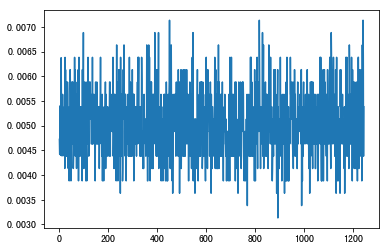

In [12]:
training_losses = train(5,num_steps)
plt.plot(training_losses)
plt.show()

/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullar

/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/caijie/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullar


 EPOCH 0
Average loss at step 100 for last 100 steps: 0.00612698674202
Average loss at step 200 for last 100 steps: 0.00611189961433
Average loss at step 300 for last 100 steps: 0.00636170685291
Average loss at step 400 for last 100 steps: 0.00676086306572
Average loss at step 500 for last 100 steps: 0.00696432411671
Average loss at step 600 for last 100 steps: 0.00676354706287
Average loss at step 700 for last 100 steps: 0.00658714413643
Average loss at step 800 for last 100 steps: 0.00675344228745
Average loss at step 900 for last 100 steps: 0.00606065869331
Average loss at step 1000 for last 100 steps: 0.00669437408447
Average loss at step 1100 for last 100 steps: 0.00640906095505
Average loss at step 1200 for last 100 steps: 0.00669491767883
Average loss at step 1300 for last 100 steps: 0.00658537089825
Average loss at step 1400 for last 100 steps: 0.00499543577433
Average loss at step 1500 for last 100 steps: 0.00582120478153
Average loss at step 1600 for last 100 steps: 0.005356

Average loss at step 13100 for last 100 steps: 0.00598557829857
Average loss at step 13200 for last 100 steps: 0.00496373474598
Average loss at step 13300 for last 100 steps: 0.00555088222027
Average loss at step 13400 for last 100 steps: 0.00579398274422
Average loss at step 13500 for last 100 steps: 0.00596034228802
Average loss at step 13600 for last 100 steps: 0.00716067314148
Average loss at step 13700 for last 100 steps: 0.0063054561615
Average loss at step 13800 for last 100 steps: 0.00604588806629
Average loss at step 13900 for last 100 steps: 0.00624220490456
Average loss at step 14000 for last 100 steps: 0.00604621589184
Average loss at step 14100 for last 100 steps: 0.00563490748405
Average loss at step 14200 for last 100 steps: 0.0071887499094
Average loss at step 14300 for last 100 steps: 0.00578392028809
Average loss at step 14400 for last 100 steps: 0.00624545276165
Average loss at step 14500 for last 100 steps: 0.00574135184288
Average loss at step 14600 for last 100 st

Average loss at step 1100 for last 100 steps: 0.00624753952026
Average loss at step 1200 for last 100 steps: 0.00581322789192
Average loss at step 1300 for last 100 steps: 0.00567038238049
Average loss at step 1400 for last 100 steps: 0.00628666222095
Average loss at step 1500 for last 100 steps: 0.00634530603886
Average loss at step 1600 for last 100 steps: 0.00666896343231
Average loss at step 1700 for last 100 steps: 0.00591654002666
Average loss at step 1800 for last 100 steps: 0.00578426122665
Average loss at step 1900 for last 100 steps: 0.00648014545441
Average loss at step 2000 for last 100 steps: 0.00683946788311
Average loss at step 2100 for last 100 steps: 0.00621709764004
Average loss at step 2200 for last 100 steps: 0.00525670647621
Average loss at step 2300 for last 100 steps: 0.00609576702118
Average loss at step 2400 for last 100 steps: 0.00695015013218
Average loss at step 2500 for last 100 steps: 0.00650997102261
Average loss at step 2600 for last 100 steps: 0.0053955

Average loss at step 14100 for last 100 steps: 0.00578272342682
Average loss at step 14200 for last 100 steps: 0.00649541974068
Average loss at step 14300 for last 100 steps: 0.00640415787697
Average loss at step 14400 for last 100 steps: 0.00515988111496
Average loss at step 14500 for last 100 steps: 0.00695792198181
Average loss at step 14600 for last 100 steps: 0.00655750334263
Average loss at step 14700 for last 100 steps: 0.00652529120445
Average loss at step 14800 for last 100 steps: 0.00581945061684
Average loss at step 14900 for last 100 steps: 0.00635095000267
Average loss at step 15000 for last 100 steps: 0.00603799939156
Average loss at step 15100 for last 100 steps: 0.00622637271881
Average loss at step 15200 for last 100 steps: 0.00621214747429
Average loss at step 15300 for last 100 steps: 0.00641227543354
Average loss at step 15400 for last 100 steps: 0.00599910497665
Average loss at step 15500 for last 100 steps: 0.00526887595654
Average loss at step 15600 for last 100 

Average loss at step 2100 for last 100 steps: 0.00670546531677
Average loss at step 2200 for last 100 steps: 0.00678084075451
Average loss at step 2300 for last 100 steps: 0.00503089487553
Average loss at step 2400 for last 100 steps: 0.00646460533142
Average loss at step 2500 for last 100 steps: 0.0053579223156
Average loss at step 2600 for last 100 steps: 0.00563588142395
Average loss at step 2700 for last 100 steps: 0.00576939284801
Average loss at step 2800 for last 100 steps: 0.00592771351337
Average loss at step 2900 for last 100 steps: 0.00562668025494
Average loss at step 3000 for last 100 steps: 0.00614705145359
Average loss at step 3100 for last 100 steps: 0.00595337212086
Average loss at step 3200 for last 100 steps: 0.0057149285078
Average loss at step 3300 for last 100 steps: 0.00626499474049
Average loss at step 3400 for last 100 steps: 0.00631878495216
Average loss at step 3500 for last 100 steps: 0.00602763533592
Average loss at step 3600 for last 100 steps: 0.005737961

Average loss at step 15100 for last 100 steps: 0.0051387912035
Average loss at step 15200 for last 100 steps: 0.0055816757679
Average loss at step 15300 for last 100 steps: 0.00594570994377
Average loss at step 15400 for last 100 steps: 0.00625442743301
Average loss at step 15500 for last 100 steps: 0.00630955576897
Average loss at step 15600 for last 100 steps: 0.00565168738365
Average loss at step 15700 for last 100 steps: 0.00593162000179
Average loss at step 15800 for last 100 steps: 0.00641726016998
Average loss at step 15900 for last 100 steps: 0.00574580252171
Average loss at step 16000 for last 100 steps: 0.00613997936249
Average loss at step 16100 for last 100 steps: 0.00527814507484
Average loss at step 16200 for last 100 steps: 0.00682639718056
Average loss at step 16300 for last 100 steps: 0.006256275177
Average loss at step 16400 for last 100 steps: 0.00647194623947
Average loss at step 16500 for last 100 steps: 0.00568771243095
Average loss at step 16600 for last 100 step

Average loss at step 3100 for last 100 steps: 0.00637260437012
Average loss at step 3200 for last 100 steps: 0.00504453897476
Average loss at step 3300 for last 100 steps: 0.00582820951939
Average loss at step 3400 for last 100 steps: 0.00477123200893
Average loss at step 3500 for last 100 steps: 0.00625636398792
Average loss at step 3600 for last 100 steps: 0.00615673542023
Average loss at step 3700 for last 100 steps: 0.00573322594166
Average loss at step 3800 for last 100 steps: 0.00620500802994
Average loss at step 3900 for last 100 steps: 0.00579676628113
Average loss at step 4000 for last 100 steps: 0.00622150301933
Average loss at step 4100 for last 100 steps: 0.00585437595844
Average loss at step 4200 for last 100 steps: 0.00556290507317
Average loss at step 4300 for last 100 steps: 0.00623350679874
Average loss at step 4400 for last 100 steps: 0.00614458084106
Average loss at step 4500 for last 100 steps: 0.00663531422615
Average loss at step 4600 for last 100 steps: 0.0060597

Average loss at step 16100 for last 100 steps: 0.00630837023258
Average loss at step 16200 for last 100 steps: 0.00658595442772
Average loss at step 16300 for last 100 steps: 0.00594988167286
Average loss at step 16400 for last 100 steps: 0.0057230836153
Average loss at step 16500 for last 100 steps: 0.00566336929798
Average loss at step 16600 for last 100 steps: 0.00576584637165
Average loss at step 16700 for last 100 steps: 0.00590969204903
Average loss at step 16800 for last 100 steps: 0.00569022536278
Average loss at step 16900 for last 100 steps: 0.005865239501
Average loss at step 17000 for last 100 steps: 0.00560348510742
Average loss at step 17100 for last 100 steps: 0.00626504123211
Average loss at step 17200 for last 100 steps: 0.00611851811409
Average loss at step 17300 for last 100 steps: 0.00551904857159
Average loss at step 17400 for last 100 steps: 0.00599371731281
Average loss at step 17500 for last 100 steps: 0.00498709976673
Average loss at step 17600 for last 100 ste

Average loss at step 4100 for last 100 steps: 0.00646718025208
Average loss at step 4200 for last 100 steps: 0.00669670403004
Average loss at step 4300 for last 100 steps: 0.00634813606739
Average loss at step 4400 for last 100 steps: 0.00601709485054
Average loss at step 4500 for last 100 steps: 0.00563186407089
Average loss at step 4600 for last 100 steps: 0.0061680996418
Average loss at step 4700 for last 100 steps: 0.0060022175312
Average loss at step 4800 for last 100 steps: 0.00597814381123
Average loss at step 4900 for last 100 steps: 0.00663709878922
Average loss at step 5000 for last 100 steps: 0.00642446398735
Average loss at step 5100 for last 100 steps: 0.00544119179249
Average loss at step 5200 for last 100 steps: 0.00624626517296
Average loss at step 5300 for last 100 steps: 0.0066325199604
Average loss at step 5400 for last 100 steps: 0.00611548781395
Average loss at step 5500 for last 100 steps: 0.00567671298981
Average loss at step 5600 for last 100 steps: 0.0059841048

Average loss at step 17100 for last 100 steps: 0.00602366328239
Average loss at step 17200 for last 100 steps: 0.00551492214203
Average loss at step 17300 for last 100 steps: 0.00659654319286
Average loss at step 17400 for last 100 steps: 0.00488594055176
Average loss at step 17500 for last 100 steps: 0.00577364325523
Average loss at step 17600 for last 100 steps: 0.00589491426945
Average loss at step 17700 for last 100 steps: 0.00581309974194
Average loss at step 17800 for last 100 steps: 0.00654812037945
Average loss at step 17900 for last 100 steps: 0.00570166885853
Average loss at step 18000 for last 100 steps: 0.00642610669136
Average loss at step 18100 for last 100 steps: 0.00547873497009
Average loss at step 18200 for last 100 steps: 0.00511740922928
Average loss at step 18300 for last 100 steps: 0.00596631348133
Average loss at step 18400 for last 100 steps: 0.00614884734154
Average loss at step 18500 for last 100 steps: 0.006718557477
Average loss at step 18600 for last 100 st

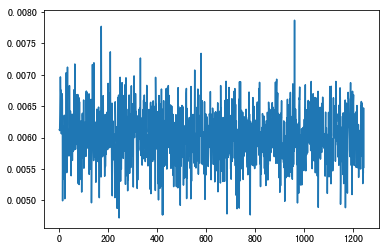

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


batch_size = 4
num_classes = 2
num_steps = 10
state_size = 4
learning_rate = 0.2


def gen_data(size = 1000000):
    """
        生成数据:
        输入数据X：在时间t，Xt的值有50%的概率为1，50%的概率为0；
        输出数据Y：在实践t，Yt的值有50%的概率为1，50%的概率为0，除此之外，如果`Xt-3 == 1`，Yt为1的概率增加50%， 如果`Xt-8 == 1`，则Yt为1的概率减少25%， 如果上述两个条件同时满足，则Yt为1的概率为75%。
    """
    X = np.array(np.random.choice(2,size=(size,)))
    Y = []
    for i in range(size):
        threhold = 0.5
        if X[i-3] == 1:
            threhold += 0.5
        if X[i-8] == 1:
            threhold -= 0.25
        if np.random.rand() > threhold:
            Y.append(0)
        else:
            Y.append(1)
    return X,np.array(Y)


def gen_batch(raw_data,batch_size,num_steps):

    raw_x,raw_y = raw_data
    data_x = raw_x.reshape(-1,batch_size,num_steps)
    data_y = raw_y.reshape(-1,batch_size,num_steps)
    for i in range(data_x.shape[0]):
        yield (data_x[i],data_y[i])


def gen_epochs(n):
    '''这里的n就是训练过程中用的epoch，即在样本规模上循环的次数'''
    for i in range(n):
        yield(gen_batch(gen_data(),batch_size,num_steps))




x = tf.placeholder(tf.int32,[batch_size,num_steps],name='input_placeholder')
y = tf.placeholder(tf.int32,[batch_size,num_steps],name='output_placeholder')

init_state = tf.zeros([batch_size,state_size])

rnn_inputs = tf.one_hot(x,num_classes)

"""
tf.unstack()　　
将给定的R维张量拆分成R-1维张量
将value根据axis分解成num个张量，返回的值是list类型，如果没有指定num则根据axis推断出！
但是dynamic不需要unstack，直接输入[batch_size,nums_step,num_classes]输入即可
"""
#rnn_inputs = tf.unstack(x_one_hot,axis=1)

cell = tf.contrib.rnn.BasicRNNCell(state_size)
#输出时[batch_size,num_steps,state_size]
rnn_outputs,final_state = tf.nn.dynamic_rnn(cell,rnn_inputs,initial_state=init_state)

with tf.variable_scope("softmax"):
    W = tf.get_variable("W",[state_size,num_classes])
    b = tf.get_variable("b",[num_classes],initializer=tf.constant_initializer(0.0))


logits = tf.reshape(tf.matmul(tf.reshape(rnn_outputs,[-1,state_size]),W)+b,[batch_size,num_steps,num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=predictions)

total_loss = tf.reduce_mean(losses)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)


def train_network(num_epochs,num_steps,state_size=4,verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx,epoch in enumerate(gen_epochs(num_epochs)):
            training_loss = 0
            training_state = np.zeros((batch_size,state_size))
            if verbose:
                print("\n EPOCH",idx)
            for step,(X,Y) in enumerate(epoch):
                tr_losses,training_loss_,training_state,_ ,_= sess.run([losses,total_loss,final_state,train_step,rnn_outputs],
                                                                     feed_dict={x:X,y:Y,init_state:training_state})
                #print(rnn_outputs.shape)
                training_loss += training_loss_

                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step",step,"for last 100 steps:",training_loss/100)
                    training_losses.append(training_loss/100)
                training_loss = 0


        return training_losses

training_losses = train_network(5,num_steps)
plt.plot(training_losses)
plt.show()